In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.12.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('data/train.csv').drop('Date',axis=1)
val_df = pd.read_csv('data/val.csv').drop('Date',axis=1)
test_df = pd.read_csv('data/test.csv').drop('Date',axis=1)

print(train_df.shape, val_df.shape, test_df.shape)

(2239, 15) (640, 15) (293, 15)


## `DataWindow` class 

In [14]:
class DataWindow():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, 
                 label_columns=None):
        
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
        inputs, labels = self.sample_batch
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_to_inputs_labels)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def test(self):
        return self.make_dataset(self.test_df)
    
    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [15]:
def compile_and_fit(model, window, patience=3, max_epochs=1000):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')
    
    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])
    
    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])
    
    return history

In [16]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## Baseline models 

In [17]:
multi_window = DataWindow(input_width=7, label_width=7, shift=7, label_columns=['Adj Close'])

### Repeat last value 

In [18]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 7, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 7, 1])

In [19]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Adj Close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 1ms/step - loss: 1.1954 - mean_absolute_error: 0.7468


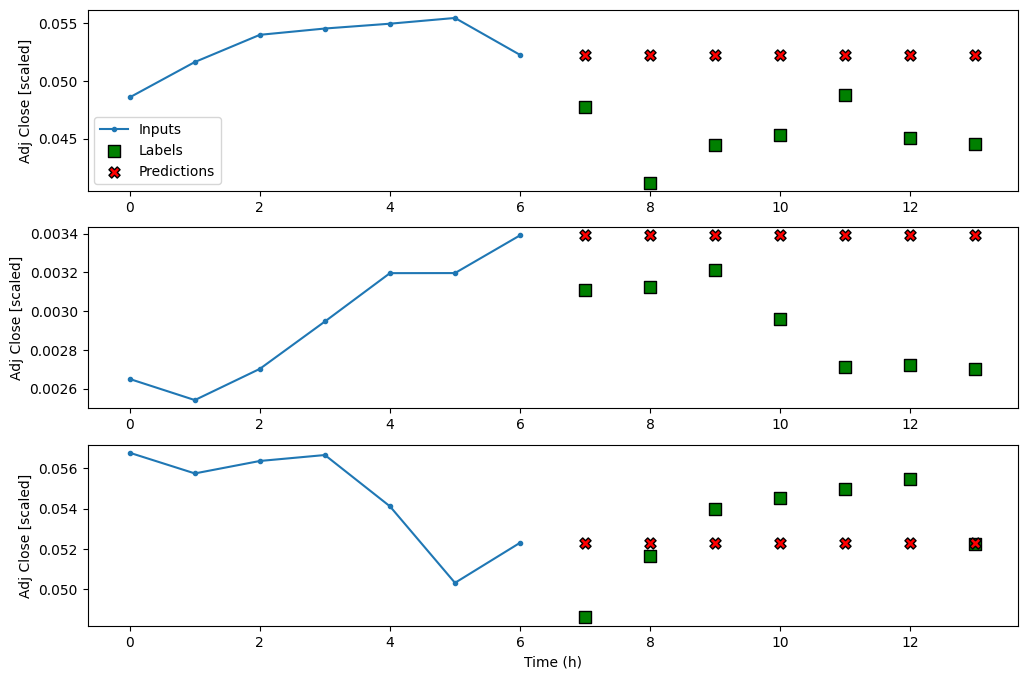

In [20]:
multi_window.plot(baseline_last)

plt.savefig('figures/CH18_F07_peixeiro.png', dpi=300)

### Repeat last day 

In [21]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [22]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Adj Close'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 1ms/step - loss: 1.2106 - mean_absolute_error: 0.7671


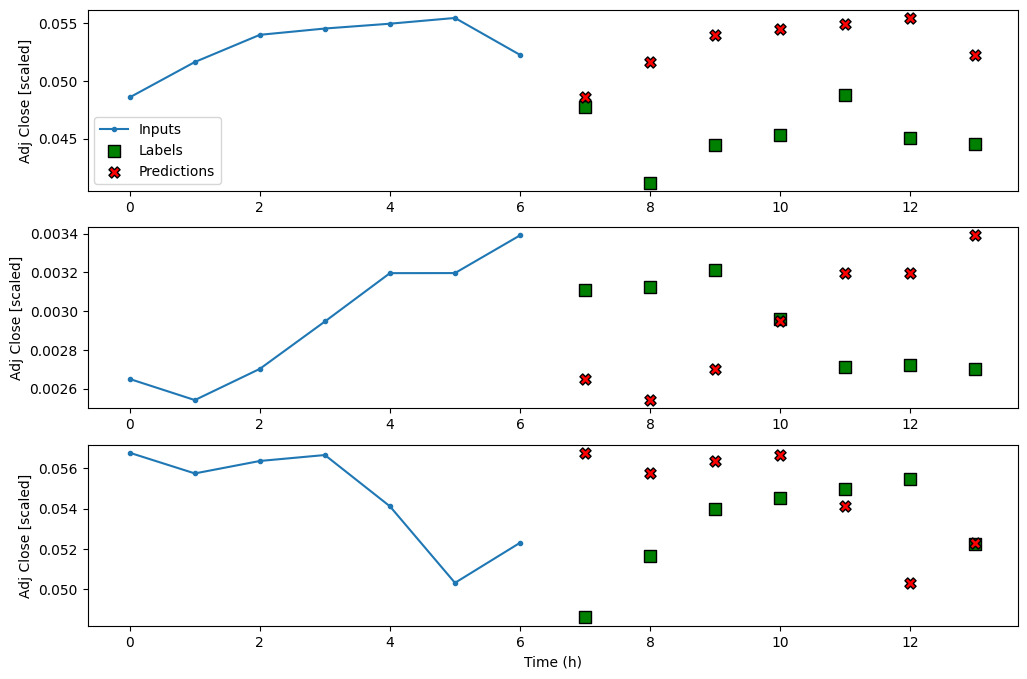

In [23]:
multi_window.plot(baseline_repeat)

plt.savefig('figures/CH18_F08_peixeiro.png', dpi=300)

## Linear model 

In [24]:
label_index = column_indices['Adj Close']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 1s 4ms/step - loss: 0.0387 - mean_absolute_error: 0.1409 - val_loss: 0.6330 - val_mean_absolute_error: 0.7333
Epoch 2/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0063 - mean_absolute_error: 0.0646 - val_loss: 0.2223 - val_mean_absolute_error: 0.4062
Epoch 3/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0032 - mean_absolute_error: 0.0430 - val_loss: 0.1065 - val_mean_absolute_error: 0.2580
Epoch 4/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0022 - mean_absolute_error: 0.0324 - val_loss: 0.0746 - val_mean_absolute_error: 0.2070
Epoch 5/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0278 - val_loss: 0.0660 - val_mean_absolute_error: 0.1932
Epoch 6/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0020 - mean_absolute_error: 0.0259 - val_loss: 0.0626 - val_mean_absolute_error: 0.1887
Epoch 7/1000
70/

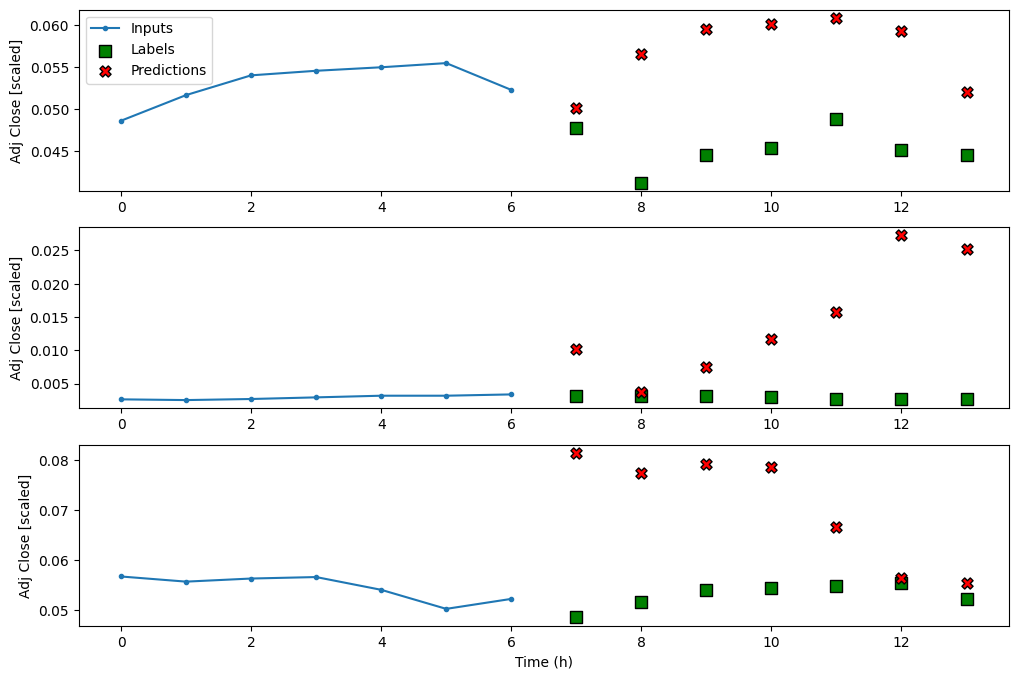

In [25]:
multi_window.plot(linear)

plt.savefig('figures/CH18_F09_peixeiro.png', dpi=300)

## Dense model 

In [26]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 1s 5ms/step - loss: 0.0238 - mean_absolute_error: 0.0955 - val_loss: 0.0963 - val_mean_absolute_error: 0.2405
Epoch 2/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0018 - mean_absolute_error: 0.0239 - val_loss: 0.1048 - val_mean_absolute_error: 0.2553
Epoch 3/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0016 - mean_absolute_error: 0.0228 - val_loss: 0.1084 - val_mean_absolute_error: 0.2623
Epoch 4/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1185 - mean_absolute_error: 0.2781


## LSTM model 

In [27]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 2s 11ms/step - loss: 0.0371 - mean_absolute_error: 0.1343 - val_loss: 1.9098 - val_mean_absolute_error: 1.2544
Epoch 2/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0062 - mean_absolute_error: 0.0506 - val_loss: 1.1279 - val_mean_absolute_error: 0.9288
Epoch 3/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0030 - mean_absolute_error: 0.0355 - val_loss: 1.0053 - val_mean_absolute_error: 0.8709
Epoch 4/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0022 - mean_absolute_error: 0.0291 - val_loss: 0.9333 - val_mean_absolute_error: 0.8335
Epoch 5/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0019 - mean_absolute_error: 0.0262 - val_loss: 0.8850 - val_mean_absolute_error: 0.8091
Epoch 6/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0018 - mean_absolute_error: 0.0244 - val_loss: 0.8469 - val_mean_absolute_error: 0.7862
Epoch 7/1000
70

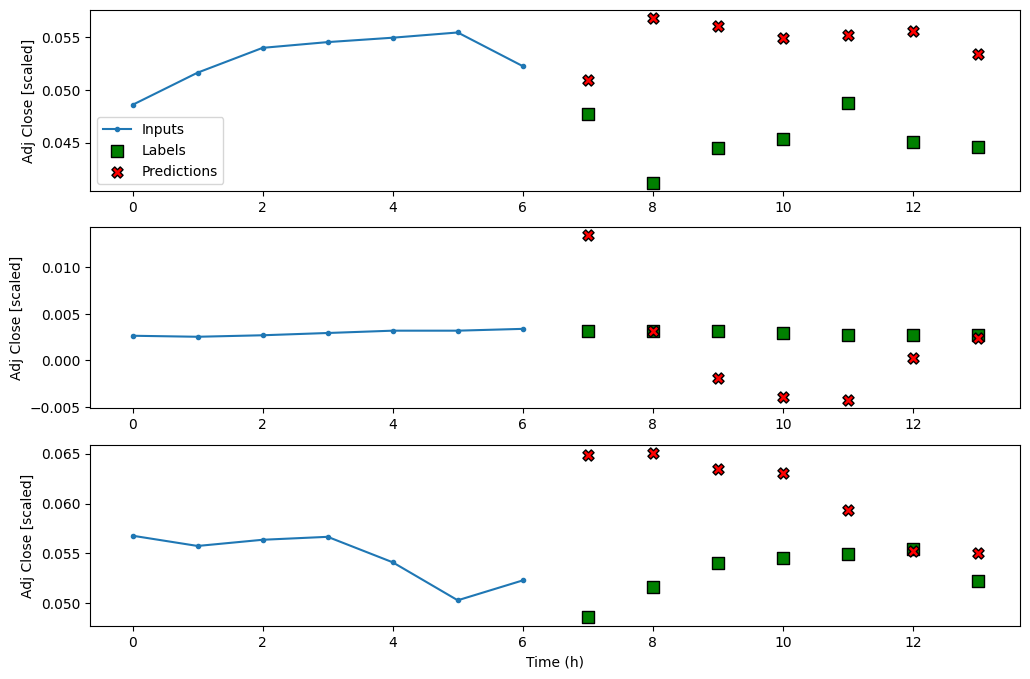

In [28]:
multi_window.plot(lstm_model)

plt.savefig('figures/CH18_F10_peixeiro.png', dpi=300)

## CNN model 

In [29]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 7
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=7, label_columns=['Adj Close'])

In [30]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 1s 4ms/step - loss: 0.0274 - mean_absolute_error: 0.1030 - val_loss: 0.0926 - val_mean_absolute_error: 0.2341
Epoch 2/1000
70/70 [==============================] - 0s 3ms/step - loss: 0.0019 - mean_absolute_error: 0.0245 - val_loss: 0.1082 - val_mean_absolute_error: 0.2585
Epoch 3/1000
70/70 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_absolute_error: 0.0232 - val_loss: 0.1212 - val_mean_absolute_error: 0.2782
Epoch 4/1000
20/20 [==============================] - 0s 1ms/step - loss: 0.1193 - mean_absolute_error: 0.2760


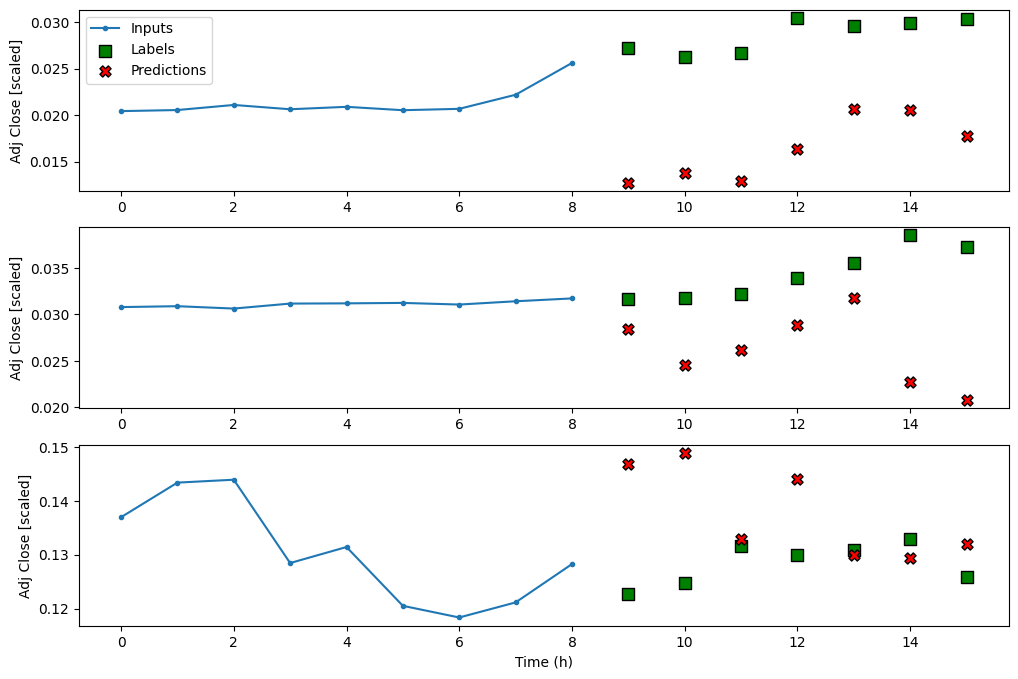

In [31]:
cnn_multi_window.plot(cnn_model)

plt.savefig('figures/CH18_F11_peixeiro.png', dpi=300)

## CNN + LSTM model 

In [32]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 2s 9ms/step - loss: 0.0313 - mean_absolute_error: 0.1179 - val_loss: 2.1405 - val_mean_absolute_error: 1.3337
Epoch 2/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0035 - mean_absolute_error: 0.0343 - val_loss: 1.7849 - val_mean_absolute_error: 1.1987
Epoch 3/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0022 - mean_absolute_error: 0.0263 - val_loss: 1.6046 - val_mean_absolute_error: 1.1221
Epoch 4/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0020 - mean_absolute_error: 0.0249 - val_loss: 1.5321 - val_mean_absolute_error: 1.0914
Epoch 5/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0018 - mean_absolute_error: 0.0231 - val_loss: 1.4630 - val_mean_absolute_error: 1.0617
Epoch 6/1000
70/70 [==============================] - 0s 4ms/step - loss: 0.0017 - mean_absolute_error: 0.0231 - val_loss: 1.4249 - val_mean_absolute_error: 1.0479
Epoch 7/1000
70/

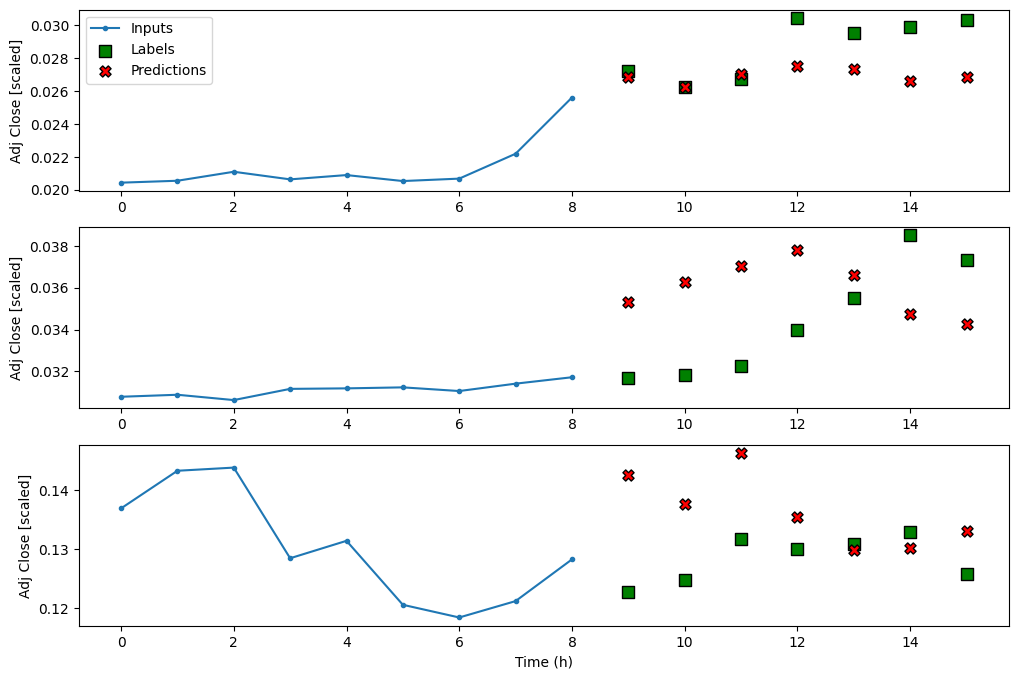

In [33]:
cnn_multi_window.plot(cnn_lstm_model)

plt.savefig('figures/CH18_F12_peixeiro.png', dpi=300)

## Autoregressive LSTM 

In [34]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
                
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)
            
            prediction = self.dense(x)
            predictions.append(prediction)
        
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

In [35]:
AR_LSTM = AutoRegressive(units=32, out_steps=7)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

Epoch 1/1000
70/70 [==============================] - 2s 8ms/step - loss: 0.0213 - mean_absolute_error: 0.0890 - val_loss: 2.1202 - val_mean_absolute_error: 1.3176
Epoch 2/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0025 - mean_absolute_error: 0.0313 - val_loss: 1.7404 - val_mean_absolute_error: 1.1753
Epoch 3/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0017 - mean_absolute_error: 0.0264 - val_loss: 1.5705 - val_mean_absolute_error: 1.1100
Epoch 4/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0244 - val_loss: 1.4686 - val_mean_absolute_error: 1.0677
Epoch 5/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0235 - val_loss: 1.4171 - val_mean_absolute_error: 1.0479
Epoch 6/1000
70/70 [==============================] - 0s 5ms/step - loss: 0.0014 - mean_absolute_error: 0.0226 - val_loss: 1.3701 - val_mean_absolute_error: 1.0267
Epoch 7/1000
70/

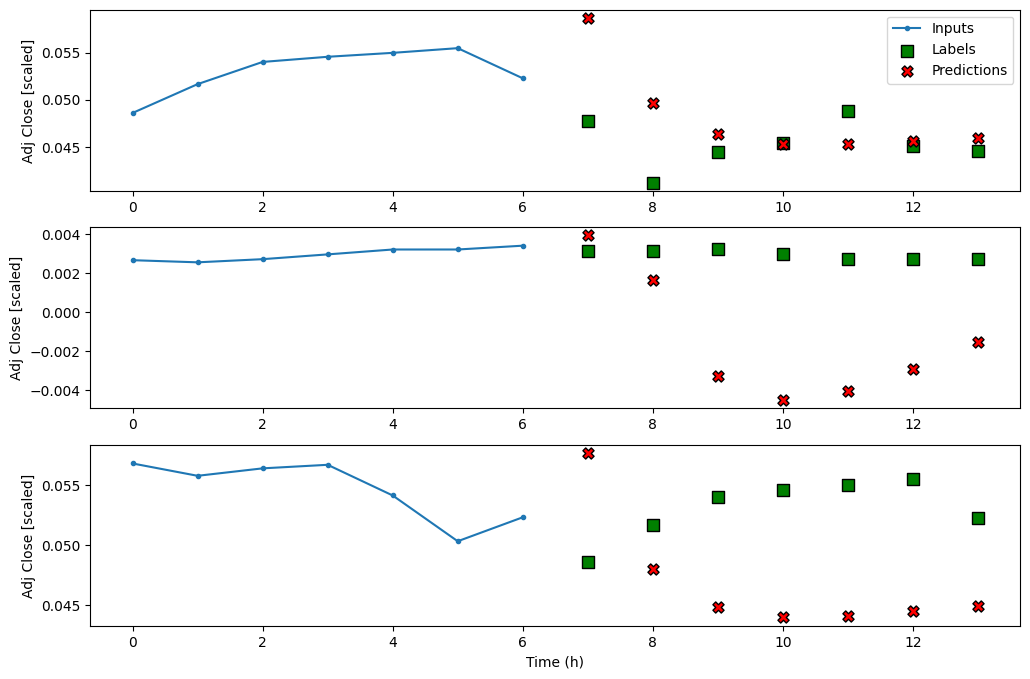

In [36]:
multi_window.plot(AR_LSTM)

plt.savefig('figures/CH18_F13_peixeiro.png', dpi=300)

In [ ]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

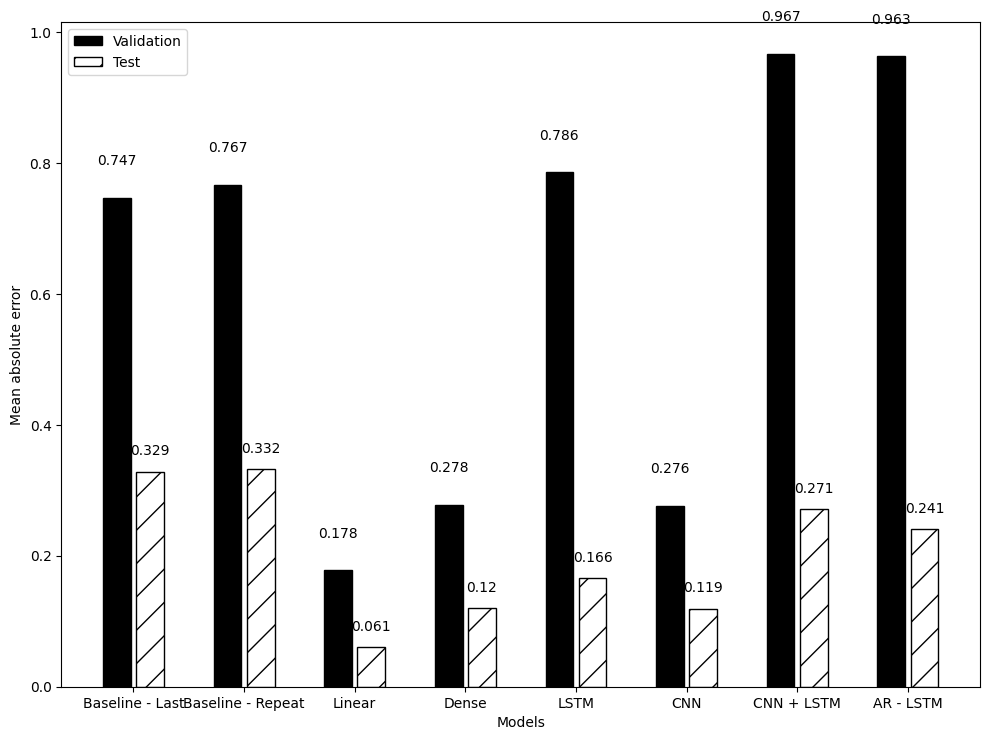

In [39]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.05, s=str(round(value, 3)), ha='center')
    
for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.025, s=str(round(value, 3)), ha='center')

# plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('figures/CH18_F14_peixeiro.png', dpi=300)